- dataset을 임의로 선정해서 직접 분석 해보기(제공한 코드를 활용해서 해보기)
- activation functions 중 relu사용시 함수 직접 정의
- lr, optimizer 등 바꿔보기
- hidden layer/neuron 수를 바꾸기
- 전처리도 추가
- 모든 시도를 올려주세요!
- 제일 높은 acc를 보인 시도를 명시해주세요!


In [ ]:
# 외부 데이터 불러오기 위해 구글 드라이브 마운트
import os
from google.colab import drive
drive.mount("/content/drive")

# 작업 디렉토리 변경 후 확인
os.chdir("/content/drive/My Drive/Colab Notebooks/data")
os.getcwd()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/content/drive/My Drive/Colab Notebooks/data'

In [ ]:
import torch
from torch import nn, optim
from torch.utils.data import  TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn.functional as F

In [ ]:
# 심장병 데이터 from Kaggle
data = pd.read_csv('heart.csv')

In [ ]:
# 303 Samples with 13 Features & Binary Outputs.
print('data shape: ', data.shape)
data

data shape:  (303, 14)


,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


# 전체 데이터 중 양성 165개, 음성 138개


# 결측치 개수 확인
 age         0
sex         0
cp          0
trtbps      0
chol        0
fbs         0
restecg     0
thalachh    0
exng        0
oldpeak     0
slp         0
caa         0
thall       0
output      0
dtype: int64


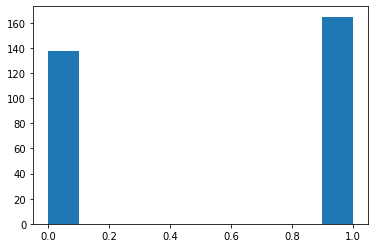

In [ ]:
# EDA
## Label 분포
plt.hist(data['output'])
print('# 전체 데이터 중 양성 {}개, 음성 {}개'.format(sum(data['output']), len(data)-sum(data['output'])))

# 결측치
print('\n\n# 결측치 개수 확인\n',data.isnull().sum())

In [ ]:
# input과 output 분리
input = data.loc[:, data.columns != 'output']
output = data.output

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == "cuda":
  torch.cuda.manual_seed_all(777)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(input, output, test_size = 0.2, random_state = 42, stratify= output.values, shuffle = True)

x_train = torch.FloatTensor(x_train.values).to(device)
y_train = torch.LongTensor(y_train.values).to(device)
x_test = torch.FloatTensor(x_test.values)
y_test = torch.LongTensor(y_test.values)

# 데이터를 tensor로 바꿔주고 gpu 연산이 가능해지도록 gpu에 옮김
# label 값을 왜 long 에 옮겨놓는가? loss function이 다르기 때문 

파이토치에서는 데이터셋을 좀 더 쉽게 다룰 수 있도록 유용한 도구로서 torch.utils.data.Dataset과 torch.utils.data.DataLoader를 제공합니다. 이를 사용하면 미니 배치 학습, 데이터 셔플(shuffle), 병렬 처리까지 간단히 수행할 수 있습니다. 기본적인 사용 방법은 Dataset을 정의하고, 이를 DataLoader에 전달하는 것
- init : class 에서 객체가 생성되면 바로 실행되는 함수
- len : observation 수를 정의하는 함수
- getitem : iteration 마다 해당하는 데이터를 돌려주는 함수

In [ ]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
  def __init__(self):
    self.x_data = x_train
    self.x_target = [[y] for y in y_train]

  def __len__(self):
    return len(self.x_data)

  def __getitem__(self, idx):
    x = torch.FloatTensor(self.x_data[idx]).to(device)
    y = torch.LongTensor(self.y_data[idx]).to(device)

    return x, y

In [ ]:
batch_size = 8

dataset = CustomDataset()
dataloader = DataLoader(dataset, batch_size=batch_size) 

In [ ]:
'''
model = nn.Sequential(
          nn.Linear(30,398, bias=True),
          nn.Sigmoid(),
          nn.Linear(398,15, bias=True),
          nn.Sigmoid(),
          nn.Linear(15,5, bias=True), 
          nn.Softmax()
          ).to(device)
'''

'\nmodel = nn.Sequential(\n          nn.Linear(30,398, bias=True),\n          nn.Sigmoid(),\n          nn.Linear(398,15, bias=True),\n          nn.Sigmoid(),\n          nn.Linear(15,5, bias=True), \n          nn.Softmax()\n          ).to(device)\n'

class로 구현 가능
- init : 초기 생성 함수
- foward : 순전파(입력값 => 예측값 의 과정)

In [ ]:
# ReLU & Leaky ReLU
def relu(x):
  a = torch.zeros_like(x)
  return torch.max(x, a)

def leaky_relu(x):
  return torch.max(x, 0.01*x)

## Optimizer
Optimizer로는 AdamW를 사용했습니다. AdamW는 Adam에 L2 regularization이 포함된 형태라고 이해하면 편합니다.

# AdamW
L2 regularization이 추가된 loss function을 Adam을 이용해 최적화할 경우 일반화 효과가 떨어질 수 있다고 합니다.

(weight update 수식을 써보면 decay rate lambda에 다른 숫자가 곱해져 의도한 만큼(lambda만큼)의 가중치 감소를 일으키지 않음.)

AdamW는 l2 reg을 optimizer에 적용시켜 이러한 문제를 해결.
-> 더 좋은 일반화 능력!



#모델 1

In [ ]:
# 모델1 : 첫번째 층에 배치정규화, 활성화 함수는 ReLU 사용
class Model(torch.nn.Module):

  def __init__(self):
    super(Model, self).__init__()
    self.layer1 = nn.Linear(13,32, bias=True)
    self.bnorm1 = nn.BatchNorm1d(32)
    self.layer2 = nn.Linear(32,16, bias=True)
    self.layer3 = nn.Linear(16,8, bias=True)
    self.layer4 = nn.Linear(8,2, bias=True)

# 활성화함수는 forward 메서드에 넣어줘도 무방합니다. 함수형 API를 사용합니다.
  def forward(self,x):
    output = self.layer1(x)
    output = F.relu(output)
    output = self.bnorm1(output)

    output = self.layer2(output)
    output = F.relu(output)

    output = self.layer3(output)
    output = F.relu(output)
    
    output = self.layer4(output)
    output = F.sigmoid(output)
    return output

In [ ]:
def init_weights(layer):
    if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_uniform(layer.weight)
        layer.bias.data.fill_(0.01)

        #xavier사용
        # Layer의 weight를 어떤 분포를 가지도록 초기화시켜줌+global minimum찾기 위해서

In [ ]:
model = Model().to(device)
model.apply(init_weights)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until


Model(
  (layer1): Linear(in_features=13, out_features=32, bias=True)
  (bnorm1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer2): Linear(in_features=32, out_features=16, bias=True)
  (layer3): Linear(in_features=16, out_features=8, bias=True)
  (layer4): Linear(in_features=8, out_features=2, bias=True)
)

In [ ]:
loss_fn  = nn.CrossEntropyLoss().to(device)

optimizer = optim.AdamW(model.parameters(), lr= 0.01)


In [ ]:
losses = []
for epoch in range(100):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


0 0.6727545857429504
10 0.5902107357978821
20 0.5522922277450562
30 0.48779693245887756
40 0.4532370865345001
50 0.4338343143463135
60 0.41590866446495056
70 0.400653213262558
80 0.390676885843277
90 0.3853859007358551


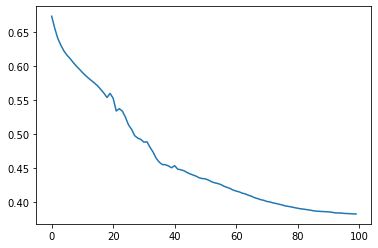

In [ ]:
plt.plot(losses)
plt.show()

In [ ]:
# Train Acc
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_train.to('cpu'))
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_train.to('cpu')))

print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [3.8052495e-12 1.0000000e+00]
argmax를 한 후의 output은 1
accuracy는 0.9338842975206612


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [ ]:
# Test Acc
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [1.000000e+00 1.733809e-07]
argmax를 한 후의 output은 0
accuracy는 0.7868852459016393


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


# 모델2

In [ ]:
# 모델2 : ReLU 대신 LeakyReLU를 사용했습니다. 
## ReLU보다 미세하게 좋은 Test Acc를 반환하지만 
## LeakyReLU의 계산비용이 훨씬 많은 것을 감안하여 ReLU를 사용하는 게 나은 것 같습니다.
class Model(torch.nn.Module):

  def __init__(self):
    super(Model, self).__init__()
    self.layer1 = nn.Linear(13,32, bias=True)
    self.bnorm1 = nn.BatchNorm1d(32)
    self.layer2 = nn.Linear(32,16, bias=True)
    self.layer3 = nn.Linear(16,8, bias=True)
    self.layer4 = nn.Linear(8,2, bias=True)



  def forward(self,x):
    output = self.layer1(x)
    output = leaky_relu(output)
    output = self.bnorm1(output)


    output = self.layer2(output)
    output = leaky_relu(output)

    output = self.layer3(output)
    output = leaky_relu(output)
    
    output = self.layer4(output)
    output = F.sigmoid(output)
    return output

In [ ]:
model = Model().to(device)
model.apply(init_weights)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until


Model(
  (layer1): Linear(in_features=13, out_features=32, bias=True)
  (bnorm1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer2): Linear(in_features=32, out_features=16, bias=True)
  (layer3): Linear(in_features=16, out_features=8, bias=True)
  (layer4): Linear(in_features=8, out_features=2, bias=True)
)

In [ ]:
loss_fn  = nn.CrossEntropyLoss().to(device)

optimizer = optim.AdamW(model.parameters(), lr= 0.01)


In [ ]:
losses = []
for epoch in range(100):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


0 0.7006872296333313
10 0.5899235010147095
20 0.5387086868286133
30 0.4962954819202423
40 0.46534034609794617
50 0.4344377815723419
60 0.4188210964202881
70 0.40913480520248413
80 0.40097418427467346
90 0.3929348886013031


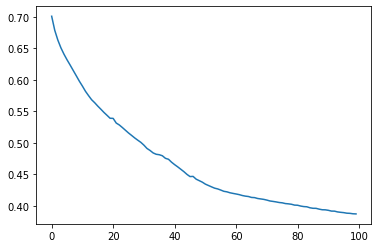

In [ ]:
plt.plot(losses)
plt.show()

In [ ]:
# Train Acc
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_train.to('cpu'))
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_train.to('cpu')))

print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [4.0535610e-06 9.9998343e-01]
argmax를 한 후의 output은 1
accuracy는 0.9090909090909091


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [ ]:
# Test Acc
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [1.000000e+00 6.412281e-08]
argmax를 한 후의 output은 0
accuracy는 0.8032786885245902


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


# 모델 3

In [ ]:
# 모델 3 : batchnorm 추가, 처음 두 Layer에 dropout 추가
class Model(torch.nn.Module):

  def __init__(self):
    super(Model, self).__init__()
    self.layer1 = nn.Linear(13,32, bias=True)
    self.bnorm1 = nn.BatchNorm1d(32)

    self.layer2 = nn.Linear(32,16, bias=True)
    self.bnorm2 = nn.BatchNorm1d(16)

    self.layer3 = nn.Linear(16,8, bias=True)

    self.layer4 = nn.Linear(8,2, bias=True)

    self.dropout = nn.Dropout(0.25)

  def forward(self,x):
    output = self.layer1(x)
    output = relu(output)
    output = self.bnorm1(output)
    output = self.dropout(output)

    output = self.layer2(output)
    output = relu(output)
    output = self.bnorm2(output)
    output = self.dropout(output)


    output = self.layer3(output)
    output = relu(output)
    output = self.dropout(output)

    output = self.layer4(output)
    output = F.sigmoid(output)
    return output

In [ ]:
model = Model().to(device)
model.apply(init_weights)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until


Model(
  (layer1): Linear(in_features=13, out_features=32, bias=True)
  (bnorm1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer2): Linear(in_features=32, out_features=16, bias=True)
  (bnorm2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer3): Linear(in_features=16, out_features=8, bias=True)
  (layer4): Linear(in_features=8, out_features=2, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [ ]:
loss_fn  = nn.CrossEntropyLoss().to(device)

optimizer = optim.AdamW(model.parameters(), lr= 0.01)


In [ ]:
losses = []
for epoch in range(100):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


0 0.712030827999115
10 0.6174102425575256
20 0.5924801826477051
30 0.5461984872817993
40 0.5051292777061462
50 0.4971320331096649
60 0.4733648896217346
70 0.48822471499443054
80 0.4759870171546936
90 0.4533664882183075


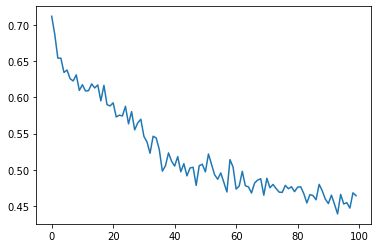

In [ ]:
plt.plot(losses)
plt.show()

In [ ]:
# Train Acc
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_train.to('cpu'))
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_train.to('cpu')))

print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [1.3168949e-05 9.9998319e-01]
argmax를 한 후의 output은 1
accuracy는 0.8801652892561983


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [ ]:
# Test Acc
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [9.9961084e-01 1.8045971e-04]
argmax를 한 후의 output은 0
accuracy는 0.8524590163934426


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


# 모델 4

In [ ]:
# 모델 4 : 세 번째 계층에도 dropout 추가 ## Best Model
class Model(torch.nn.Module):

  def __init__(self):
    super(Model, self).__init__()
    self.layer1 = nn.Linear(13,32, bias=True)
    self.bnorm1 = nn.BatchNorm1d(32)

    self.layer2 = nn.Linear(32,16, bias=True)
    self.bnorm2 = nn.BatchNorm1d(16)

    self.layer3 = nn.Linear(16,8, bias=True)

    self.layer4 = nn.Linear(8,2, bias=True)

    self.dropout = nn.Dropout(0.25)

  def forward(self,x):
    output = self.layer1(x)
    output = relu(output)
    output = self.bnorm1(output)
    output = self.dropout(output)

    output = self.layer2(output)
    output = relu(output)
    output = self.bnorm2(output)
    output = self.dropout(output)


    output = self.layer3(output)
    output = relu(output)
    output = self.dropout(output)

    output = self.layer4(output)
    output = F.sigmoid(output)
    return output

In [ ]:
model = Model().to(device)
model.apply(init_weights)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until


Model(
  (layer1): Linear(in_features=13, out_features=32, bias=True)
  (bnorm1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer2): Linear(in_features=32, out_features=16, bias=True)
  (bnorm2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer3): Linear(in_features=16, out_features=8, bias=True)
  (layer4): Linear(in_features=8, out_features=2, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [ ]:
loss_fn  = nn.CrossEntropyLoss().to(device)

optimizer = optim.AdamW(model.parameters(), lr= 0.01)


In [ ]:
losses = []
for epoch in range(100):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


0 0.7357624173164368
10 0.649552047252655
20 0.609990656375885
30 0.5860590934753418
40 0.5772994756698608
50 0.523971676826477
60 0.49679550528526306
70 0.5004668235778809
80 0.47349393367767334
90 0.473147451877594


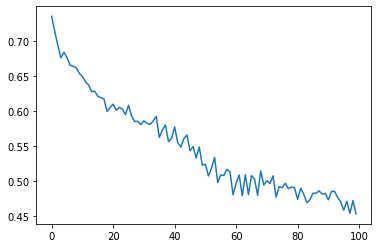

In [ ]:
plt.plot(losses)
plt.show()

In [ ]:
# Train Acc
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_train.to('cpu'))
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_train.to('cpu')))

print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [0.46938908 0.67631054]
argmax를 한 후의 output은 1
accuracy는 0.8512396694214877


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [ ]:
# Test Acc
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [9.9999487e-01 1.0352101e-04]
argmax를 한 후의 output은 0
accuracy는 0.819672131147541


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
